### Trial Distances by dimension type
- Have a suspiscion that High X within-dim trials are closer together, which would make them more affected by nonsense correlations, providing an explanation for why decoder weights are closer together

### Per pair, per session in pair, find High X for feat1, feat2, compute num trials distance between feats

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
from spike_tools import (
    general as spike_general,
    analysis as spike_analysis,
)
import utils.behavioral_utils as behavioral_utils
import utils.spike_utils as spike_utils
import utils.io_utils as io_utils
import os
from distutils.util import strtobool

import argparse
from tqdm import tqdm
from matplotlib import pyplot as plt
import seaborn as sns
from scripts.anova_analysis.anova_configs import *
from constants.behavioral_constants import *

from scipy import stats
from scipy.spatial.distance import pdist, cdist


In [2]:
sub = "SA"
SESSIONS_PATH = "/data/patrick_res/sessions/{sub}/valid_sessions.pickle"
SA_MORE_SESS_PAIRS_PATH = "/data/patrick_res/sessions/SA/pairs_at_least_3blocks_10sess_more_sess.pickle"

valid_sess = pd.read_pickle(SESSIONS_PATH.format(sub=sub))
pairs = pd.read_pickle(SA_MORE_SESS_PAIRS_PATH)

In [7]:
def compute_pairwise_stats_by_pair(beh_a, beh_b, mean=True):
    trial_dists = cdist(
        beh_a.TrialNumber.values.reshape(-1, 1), 
        beh_b.TrialNumber.values.reshape(-1, 1), 
        metric='euclidean')
    if mean:
        return np.mean(trial_dists)
    else: 
        return trial_dists.reshape(-1)

def time_balance_conds_by_pair(beh_a, beh_b, num_iters, target_mean, sample_size=None, seed=42):
    """
    Sample from behavior, such that distribution of subsample trial number distances 
    in subsample is as close to target mean/std as possible
    """
    lowest_err = np.inf   
    best_sub_a_trials = None
    best_sub_b_trials = None
    rng = np.random.default_rng(seed=seed)
    sample_size = np.min((len(beh_a), len(beh_b))) if sample_size is None else sample_size
    for i in range(num_iters):
        idx_a = rng.choice(len(beh_a), size=sample_size, replace=False)
        sub_beh_a = beh_a.iloc[idx_a]

        idx_b = rng.choice(len(beh_b), size=sample_size, replace=False)
        sub_beh_b = beh_b.iloc[idx_b]
        mean = compute_pairwise_stats_by_pair(sub_beh_a, sub_beh_b)
        # just weight mean and std equally at this point, 
        # err = 2 * (mean - target_mean) ** 2 + (std - target_std) **2
        err = (mean - target_mean) ** 2
        if err < lowest_err:
            best_sub_a_trials = sub_beh_a.TrialNumber.values
            best_sub_b_trials = sub_beh_b.TrialNumber.values

            lowest_err = err
    return best_sub_a_trials, best_sub_b_trials, lowest_err


def get_high_x_trials(beh, feat):
    beh = behavioral_utils.get_feat_choice_label(beh, feat)
    beh = behavioral_utils.filter_behavior(beh, {"Response": "Correct", "Choice": "Chose"})
    beh = behavioral_utils.get_belief_partitions(beh, feat, use_x=True)
    beh = beh[beh["BeliefPartition"] == "High X"]
    return beh

def process_session(session, pair, rebalance_mean):
    feat1, feat2 = pair
    beh = behavioral_utils.get_valid_belief_beh_for_sub_sess("SA", session)
    feat1_beh = get_high_x_trials(beh, feat1)
    feat2_beh = get_high_x_trials(beh, feat2)
    if rebalance_mean is not None: 
        sample_size = np.min((len(feat1_beh) - 10, len(feat2_beh) - 10))
        sub_feat1_trials, sub_feat2_trials, _ = time_balance_conds_by_pair(feat1_beh, feat2_beh, 5000, rebalance_mean, sample_size)
        feat1_beh = feat1_beh[feat1_beh.TrialNumber.isin(sub_feat1_trials)]
        feat2_beh = feat2_beh[feat2_beh.TrialNumber.isin(sub_feat2_trials)]

    # cross = pd.merge(feat1_beh, feat2_beh, how="cross")
    # dist = np.abs(cross.TrialNumber_x - cross.TrialNumber_y)

    dists = compute_pairwise_stats_by_pair(feat1_beh, feat2_beh, mean=False)
    return pd.DataFrame({"dist": dists})


def process_pair(row, rebalance_mean=None):
    res = []
    for session in row.sessions:
        res.append(process_session(session, row.pair, rebalance_mean))
    res = pd.concat(res)
    res["dim_type"] = row.dim_type
    return res

In [4]:
tqdm.pandas()
res = pd.concat(pairs.progress_apply(process_pair, axis=1).values)

100%|██████████| 17/17 [00:24<00:00,  1.43s/it]


Text(0.5, 0, "Num trials between High X's for pairs of features")

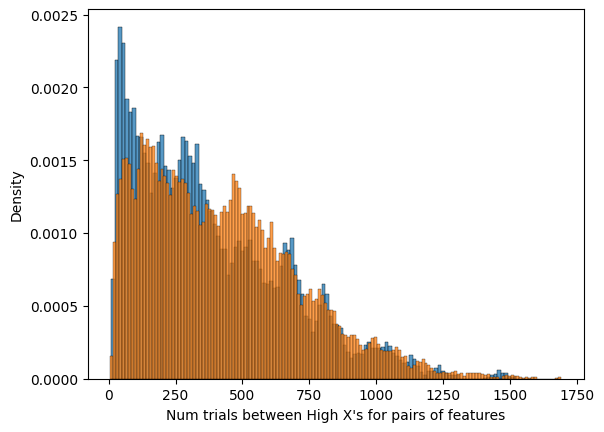

In [5]:
fig, ax = plt.subplots()
sns.histplot(res[res.dim_type == "within dim"], x="dist", stat="density", ax=ax)
sns.histplot(res[res.dim_type == "across dim"], x="dist", stat="density", ax=ax)

ax.set_xlabel("Num trials between High X's for pairs of features")

In [8]:
print(f"mean for all: {res.dist.mean()}")
print(f"mean for within: {res[res.dim_type == 'within dim'].dist.mean()}")
print(f"mean for across: {res[res.dim_type == 'across dim'].dist.mean()}")

mean for all: 409.06459440562634
mean for within: 381.0846912106682
mean for across: 425.5044351367299


In [9]:
balanced_res = pd.concat(pairs.progress_apply(lambda x: process_pair(x, res.dist.mean()), axis=1).values)

100%|██████████| 17/17 [04:21<00:00, 15.35s/it]


Text(0.5, 0, "Num trials between High X's for pairs of features")

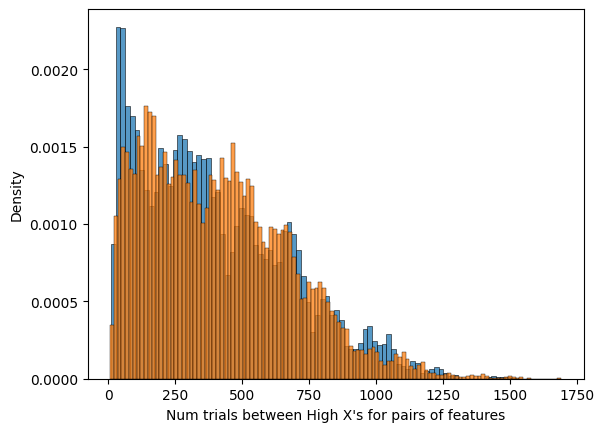

In [10]:
fig, ax = plt.subplots()
sns.histplot(balanced_res[balanced_res.dim_type == "within dim"], x="dist", stat="density", ax=ax)
sns.histplot(balanced_res[balanced_res.dim_type == "across dim"], x="dist", stat="density", ax=ax)

ax.set_xlabel("Num trials between High X's for pairs of features")

In [11]:
print(f"mean for all: {balanced_res.dist.mean()}")
print(f"mean for within: {balanced_res[balanced_res.dim_type == 'within dim'].dist.mean()}")
print(f"mean for across: {balanced_res[balanced_res.dim_type == 'across dim'].dist.mean()}")

mean for all: 407.7143620905943
mean for within: 397.11778687570336
mean for across: 413.6796631367387
